In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

from sodapy import Socrata

## Collect Resturant Inspection Data from Socrata api

https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j
https://dev.socrata.com/foundry/data.cityofnewyork.us/43nn-pn8j

In [2]:
client = Socrata("data.cityofnewyork.us", None)
results = client.get("43nn-pn8j", limit=500000)
dohmn_raw = pd.DataFrame.from_records(results)

In [3]:
# restaurants[restaurants.score >= 28]
def preprocess_dohmn(dohmn_raw):
    restaurants = dohmn_raw.drop(['bin', 'bbl','nta','phone','census_tract','council_district','community_board' ], axis = 1)
    restaurants = restaurants[~restaurants.zipcode.isnull()]
    restaurants = restaurants[(restaurants.zipcode != 'N/A')]
    restaurants['zipcode'] = restaurants.zipcode.astype(int)
    restaurants['score'] = restaurants['score'].astype(float)
    restaurants['close'] = restaurants['score'].apply(lambda x: 1 if x > 27 else 0)
    restaurants['latitude'] = restaurants.latitude.astype(float)
    restaurants['longitude'] = restaurants.longitude.astype(float)
    restaurants = restaurants[(restaurants.latitude < 40.85) & (restaurants.latitude > 40.63) &
           (restaurants.longitude > -74.03) & (restaurants.longitude < -73.75)]
    restaurants = restaurants[restaurants.zipcode <= 11697]
    return restaurants

In [4]:
restaurants = preprocess_dohmn(dohmn_raw)

In [10]:
# np.save( 'unique_zipcode.npy',pd.unique(restaurants.zipcode))

## Visulization of Restaurant Inspection Score

‘A’ — indicates a score of 0–13 \
‘B’ — indicates a score of 14–27 \
‘C’ — indicates a score of greater than 27 \
‘Grade Pending’ — indicates the restaurant received an ‘B’ or a ‘C’ and is contesting the grade. \
if the restaurant recieve more than 28 score, then the resturant will be closed until next inspection
https://www.nytimes.com/2017/05/17/nyregion/new-york-today-what-do-restaurant-grades-mean.html \
https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j \
https://docs.google.com/presentation/d/1pSC0NFqhwqRO36UCAgwElhfs5zsi28Bk-fI0yPt6peU/edit#slide=id.g6df4927a1c_0_10

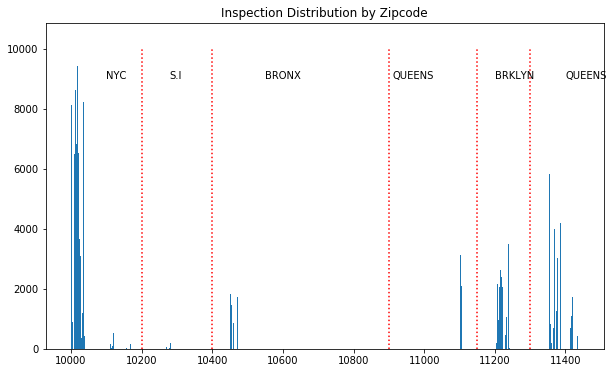

In [75]:
def draw_zipcode(restaurants):
    # groupby zipcode
    inspectation_time =restaurants[['score', 'zipcode']].\
                    groupby('zipcode', as_index= False).count().\
                    rename(columns = {'score': 'Inspection Times'})
    
    # draw distribution
    plt.figure(figsize=(10,6))
    plt.hist(restaurants['zipcode'], bins = int(max(restaurants['zipcode']) - min(restaurants['zipcode'] +1)))
    plt.vlines(x = 10200, ymin =0, ymax = 10000, color = 'r', linestyles='dotted')
    plt.vlines(x = 10400, ymin =0, ymax = 10000, color = 'r', linestyles='dotted')
    plt.vlines(x = 10900, ymin =0, ymax = 10000, color = 'r', linestyles='dotted')
    plt.vlines(x = 11150, ymin =0, ymax = 10000, color = 'r', linestyles='dotted')
    plt.vlines(x = 11300, ymin =0, ymax = 10000, color = 'r', linestyles='dotted')
    plt.text(10100,9000,'NYC')
    plt.text(10280,9000,'S.I')
    plt.text(10550,9000,'BRONX')
    plt.text(10910,9000,'QUEENS')
    plt.text(11200,9000,'BRKLYN')
    plt.text(11400,9000,'QUEENS')
    plt.title('Inspection Distribution by Zipcode')
    plt.show()
# inspectation_time
draw_zipcode(restaurants)

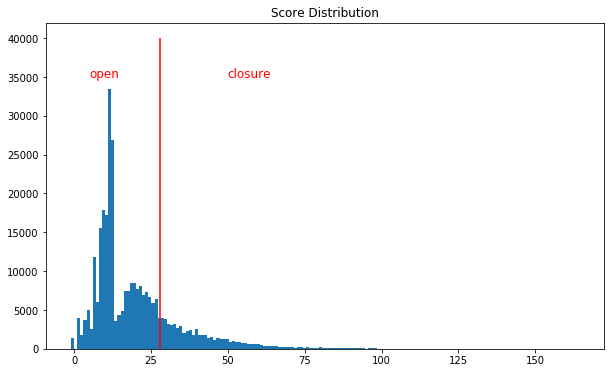

In [200]:
def plt_score(restaurants):
    plt.figure(figsize=(10,6))
    plt.hist(restaurants['score'], bins = int(max(restaurants['score']) - min(restaurants['score'] +1)))
    plt.vlines(x = 28, ymin =0, ymax = 40000, color = 'r')
    plt.title('Score Distribution')
    plt.text(5,35000,'open', fontsize=12,  color = 'r')
    plt.text(50,35000,'closure', fontsize=12, color = 'r')
    plt.show()
    
plt_score(restaurants)

## Prediction of Restaurant Closure

In [5]:
yelp_dohmh_property = pd.read_csv('yelp_dohmh_property.csv', index_col=[0])

In [15]:
def get_rf_features_label(yelp_dohmh_property):
    labels = yelp_dohmh_property['SCORE'].apply(lambda x: 1 if x > 27 else 0)
    selected_features = yelp_dohmh_property[['CUISINE DESCRIPTION','BORO', 'AVERAGE PRICE', 'review_count', 'rating', 'price']]
    selected_features['price'] = selected_features.price.astype(object)
    dummy_features = pd.get_dummies(selected_features)
    dummy_features = dummy_features.rename(columns = {'AVERAGE PRICE': 'Property Average Price'})
    return dummy_features, labels

def get_log_df(yelp_dohmh_property):
    yelp_dohmh_property['close'] = yelp_dohmh_property['SCORE'].apply(lambda x: 1 if x > 27 else 0)
    df = yelp_dohmh_property[['close','CUISINE DESCRIPTION','BORO', 'AVERAGE PRICE', 'review_count', 'rating', 'price']]
    df['price'] = df.price.astype(object)
    dummy_df = pd.get_dummies(df)
    return dummy_df

In [54]:
from sklearn.utils import resample

df = get_log_df(yelp_dohmh_property)

# Separate majority and minority classes
df_majority = df[df.close==0]
df_minority = df[df.close==1]


# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=2000,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_sampled = pd.concat([df_majority_downsampled, df_minority])


X, y = df_sampled.drop('close', axis =1), df_sampled['close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


# Display new class counts
df_sampled.close.value_counts()

0    2000
1    1330
Name: close, dtype: int64

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)
print('Accuarcy is: ', metrics.accuracy_score(y_test, y_pred))

Accuarcy is:  0.955955955955956


In [60]:
feature_importance = pd.Series(rf_clf.feature_importances_, index = X.columns).sort_values(ascending=False)
indices_scaled = np.argsort(feature_importance)[::-1]
feature_importance[:20]

AVERAGE PRICE                          0.246574
review_count                           0.235665
rating                                 0.121325
BORO_Brooklyn                          0.024238
CUISINE DESCRIPTION_Chinese            0.022765
BORO_Manhattan                         0.021661
price_2                                0.021499
CUISINE DESCRIPTION_American           0.020189
CUISINE DESCRIPTION_Bangladeshi        0.019593
price_1                                0.019554
CUISINE DESCRIPTION_Caribbean          0.016651
BORO_Queens                            0.015141
CUISINE DESCRIPTION_Spanish            0.014306
CUISINE DESCRIPTION_Mexican            0.013993
CUISINE DESCRIPTION_Indian             0.013107
CUISINE DESCRIPTION_Delicatessen       0.011436
CUISINE DESCRIPTION_Italian            0.011227
CUISINE DESCRIPTION_Pizza              0.009923
CUISINE DESCRIPTION_Café/Coffee/Tea    0.009786
CUISINE DESCRIPTION_Jewish/Kosher      0.009662
dtype: float64

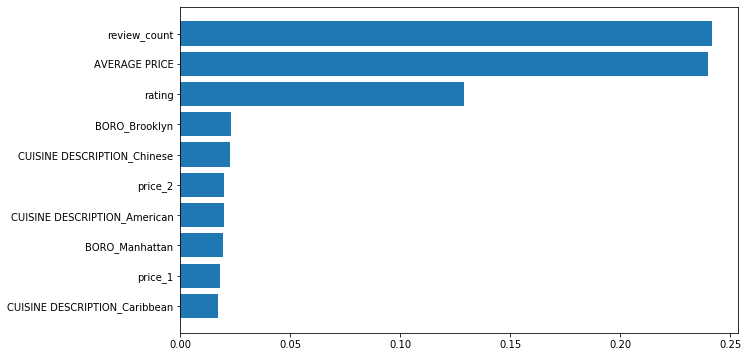

In [126]:
plt.figure(figsize=(10,6))
plt.barh(range(10),feature_importance[indices_scaled][:10][::-1])
plt.yticks(range(10), feature_importance[indices_scaled][:10][::-1].index)
plt.show()

In [65]:
clf = LogisticRegression(random_state=0)
# param_grid = {'penalty' : ['l1','l2'],'C': [0.01,0.1,1.,10.], 'intercept_scaling': [0.0005,0.001,0.005,0.01,0.1,1.,10.]}
# scorer = make_scorer(precision_score,pos_label=False)
# gscv = GridSearchCV(clf,param_grid,scoring=scorer)
result = clf.fit(X_train,y_train)

In [66]:
pd.DataFrame({'feature':X.columns[:3], 'coefficient':clf.coef_[0][:3]})


,feature,coefficient
0,AVERAGE PRICE,-0.258876
1,review_count,0.043126
2,rating,-0.185560
